In [6]:
!pip install darts transformers pandas matplotlib numpy -q

import pandas as pd
import numpy as np
from darts import TimeSeries
from darts.models import ExponentialSmoothing, NaiveSeasonal, LinearRegressionModel
from darts.metrics import mape, rmse
from transformers import pipeline
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [7]:
class TimeSeriesAgent:
    """Autonomous agent for time series analysis and forecasting"""

    def __init__(self):
        print("🤖 Initializing Agent Brain...")
        self.llm = pipeline("text-generation", model="distilgpt2", max_length=150,
                           do_sample=True, temperature=0.7)

        self.models = {
            'exponential_smoothing': ExponentialSmoothing(),
            'naive_seasonal': NaiveSeasonal(K=12),
            'linear_regression': LinearRegressionModel(lags=12)
        }
        self.selected_model = None
        self.forecast = None

    def perceive(self, data):
        """Agent perceives and analyzes the time series data"""
        print("\n👁️  PERCEPTION PHASE")
        self.ts = TimeSeries.from_dataframe(data, 'date', 'value', freq='M')

        trend = "increasing" if data['value'].iloc[-1] > data['value'].iloc[0] else "decreasing"
        volatility = data['value'].std() / data['value'].mean()
        seasonality = self._detect_seasonality(data['value'])

        analysis = {
            'length': len(data),
            'trend': trend,
            'volatility': f"{volatility:.2f}",
            'has_seasonality': seasonality,
            'mean': f"{data['value'].mean():.2f}",
            'range': f"{data['value'].min():.2f} to {data['value'].max():.2f}"
        }

        print(f"📊 Data Points: {analysis['length']}")
        print(f"📈 Trend: {analysis['trend'].upper()}")
        print(f"🎲 Volatility: {analysis['volatility']}")
        print(f"🔄 Seasonality: {'Detected' if seasonality else 'Not detected'}")

        return analysis

    def _detect_seasonality(self, series, threshold=0.3):
        """Simple seasonality detection"""
        if len(series) < 24:
            return False
        acf = np.correlate(series - series.mean(), series - series.mean(), mode='full')
        acf = acf[len(acf)//2:]
        acf /= acf[0]
        return np.max(acf[12:24]) > threshold if len(acf) > 24 else False

    def reason(self, analysis):
        """Agent reasons about which model to use"""
        print("\n🧠 REASONING PHASE")

        prompt = f"Time series analysis: {analysis['length']} data points, {analysis['trend']} trend, " \
                 f"volatility {analysis['volatility']}, seasonality: {analysis['has_seasonality']}. "

        thought = self.llm(prompt, max_length=100, num_return_sequences=1)[0]['generated_text']
        print(f"💭 Agent Thinking: {thought[:150]}...")

        if analysis['has_seasonality']:
            self.selected_model = 'naive_seasonal'
            reason = "Seasonality detected - using Naive Seasonal model"
        elif float(analysis['volatility']) > 0.3:
            self.selected_model = 'exponential_smoothing'
            reason = "High volatility - using Exponential Smoothing"
        else:
            self.selected_model = 'linear_regression'
            reason = "Stable trend - using Linear Regression"

        print(f"✅ Decision: {reason}")
        return self.selected_model

    def act(self, horizon=12):
        """Agent takes action: trains model and generates forecast"""
        print("\n⚡ ACTION PHASE")

        train, val = self.ts[:-12], self.ts[-12:]

        model = self.models[self.selected_model]
        print(f"🎯 Training {self.selected_model}...")
        model.fit(train)

        self.forecast = model.predict(horizon)

        if len(val) > 0:
            val_pred = model.predict(len(val))
            accuracy = 100 - mape(val, val_pred)
            print(f"📊 Validation Accuracy: {accuracy:.2f}%")

        print(f"🔮 Generated {horizon}-step forecast")
        return self.forecast

    def explain(self):
        """Agent explains its predictions"""
        print("\n💬 EXPLANATION PHASE")

        forecast_values = self.forecast.values().flatten()
        hist_values = self.ts.values().flatten()

        change = ((forecast_values[-1] - hist_values[-1]) / hist_values[-1]) * 100
        direction = "increase" if change > 0 else "decrease"

        explanation = f"Based on my analysis using {self.selected_model}, " \
                     f"I predict a {abs(change):.1f}% {direction} in the next period. " \
                     f"Forecast range: {forecast_values.min():.2f} to {forecast_values.max():.2f}. " \
                     f"Historical mean was {hist_values.mean():.2f}."

        print(f"📝 {explanation}")

        prompt = f"Forecast summary: {explanation} Explain implications:"
        summary = self.llm(prompt, max_length=120)[0]['generated_text']
        print(f"\n🤖 Agent Summary: {summary[:200]}...")

        return explanation

    def visualize(self):
        """Agent creates visualization of its work"""
        print("\n📊 Generating visualization...")

        plt.figure(figsize=(14, 6))

        self.ts.plot(label='Historical Data', lw=2)

        self.forecast.plot(label=f'Forecast ({self.selected_model})',
                          lw=2, linestyle='--')

        plt.title('🤖 Agentic AI Time Series Forecast', fontsize=16, fontweight='bold')
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Value', fontsize=12)
        plt.legend(loc='best', fontsize=11)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

In [8]:
def create_sample_data():
    """Generate sample time series data"""
    dates = pd.date_range(start='2020-01-01', periods=48, freq='M')
    trend = np.linspace(100, 150, 48)
    seasonality = 10 * np.sin(np.linspace(0, 4*np.pi, 48))
    noise = np.random.normal(0, 3, 48)
    values = trend + seasonality + noise

    return pd.DataFrame({'date': dates, 'value': values})

🚀 AGENTIC AI TIME SERIES FORECASTING SYSTEM

📥 Loading data...
Loaded 48 data points from 2020-01 to 2023-12
🤖 Initializing Agent Brain...


Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



👁️  PERCEPTION PHASE
📊 Data Points: 48
📈 Trend: INCREASING
🎲 Volatility: 0.11
🔄 Seasonality: Not detected

🧠 REASONING PHASE


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


💭 Agent Thinking: Time series analysis: 48 data points, increasing trend, volatility 0.11, seasonality: False.  


The above chart is the second time we have seen a ser...
✅ Decision: Stable trend - using Linear Regression

⚡ ACTION PHASE
🎯 Training linear_regression...
📊 Validation Accuracy: 88.63%
🔮 Generated 12-step forecast

💬 EXPLANATION PHASE
📝 Based on my analysis using linear_regression, I predict a 9.7% increase in the next period. Forecast range: 142.68 to 164.23. Historical mean was 125.08.

🤖 Agent Summary: Forecast summary: Based on my analysis using linear_regression, I predict a 9.7% increase in the next period. Forecast range: 142.68 to 164.23. Historical mean was 125.08. Explain implications: A tota...

📊 Generating visualization...


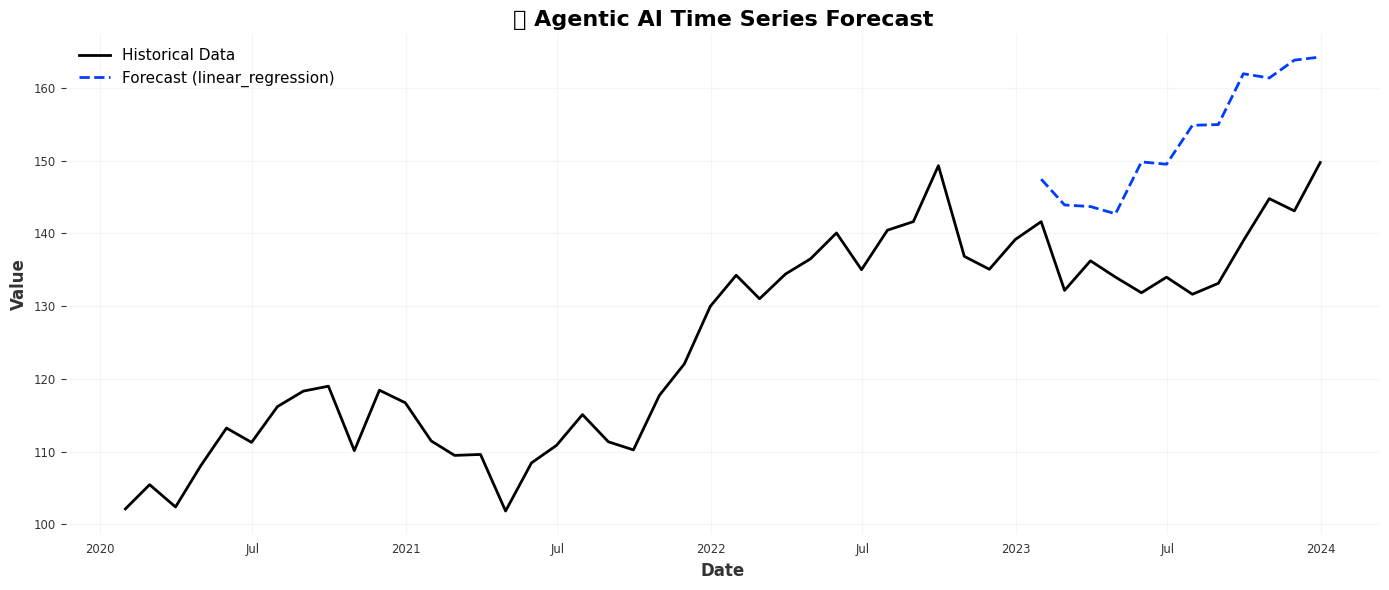


✅ AGENT COMPLETED FORECASTING TASK SUCCESSFULLY


In [9]:
def main():
    """Main execution: Agent autonomously handles forecasting task"""
    print("="*70)
    print("🚀 AGENTIC AI TIME SERIES FORECASTING SYSTEM")
    print("="*70)

    print("\n📥 Loading data...")
    data = create_sample_data()
    print(f"Loaded {len(data)} data points from 2020-01 to 2023-12")

    agent = TimeSeriesAgent()

    analysis = agent.perceive(data)
    agent.reason(analysis)
    agent.act(horizon=12)
    agent.explain()
    agent.visualize()

    print("\n" + "="*70)
    print("✅ AGENT COMPLETED FORECASTING TASK SUCCESSFULLY")
    print("="*70)

if __name__ == "__main__":
    main()